# Chi Square Tester for NRWC Workshop

In [1]:
# Import necessary functions
import pandas as pd 
import numpy as np 
import math
import helper_functions as hf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import cochrans_q
from scipy import stats
from scipy.stats import chi2
from scipy.special import gammaincc  # for calculating p-value from chi-square statistic

# Use autoreload to automatically reload changes from the Python file
%load_ext autoreload
%autoreload 2

In [2]:
# Set maximum column width and display width
pd.set_option('display.max_columns', None)      # Show all columns
#pd.set_option('display.width', 100)            # Set a wider display width
#pd.set_option('display.max_colwidth', None)     # Prevent truncation of cell content

In [3]:
"""
# Define number of participants 
# This can also be used later for power calculations 
participants = hf.get_user_input()
print(f"The number of participants is: {participants}")
"""

'\n# Define number of participants \n# This can also be used later for power calculations \nparticipants = hf.get_user_input()\nprint(f"The number of participants is: {participants}")\n'

## Read file from XLS and turn it into a dataframe 
- Remember that there are cells that can be empty if no one replies 
- Every row is a participant 

In [4]:
## Input results from quiz here

# Load data from the first sheet of an Excel file
df = pd.read_excel('NRWC-quiz.xlsx', sheet_name='Voters', usecols='A:O', skiprows=2)

# Display the first few rows
print(df.head())

         Date  Session  Voter               :             :.1       :.2  \
0  2024-11-05        1      1          Åhlens  Naturkompaniet  XS Leker   
1  2024-11-05        2      2  Naturkompaniet        XS Leker   Stadium   
2  2024-11-05        2      3         Kappahl             NaN   Stadium   
3  2024-11-05        2      4         Kappahl  Naturkompaniet  XS Leker   

       :.3      :.4       :.5             :.6      :.7       :.8       :.9  \
0  Kappahl  Stadium     Cubus  Naturkompaniet      NaN       NaN       NaN   
1   Åhlens    Cubus   Kappahl         Stadium  Kappahl  XS Leker   Stadium   
2    Cubus   Åhlens  XS Leker         Stadium    Cubus   Kappahl  XS Leker   
3  Stadium      NaN       NaN             NaN      NaN       NaN       NaN   

             :.10     :.11  
0             NaN      NaN  
1  Naturkompaniet  Kappahl  
2          Åhlens  Stadium  
3             NaN      NaN  


In [5]:
# Filtering and cleaning the DataFrame

# Do I need to handle sessions? Like just pick the latest one? 
# If required to filter on session, specify it here 
mask = df['Session'] == 2
filtered_df = df[mask]

# Rename columns from the 3rd column onward to 'Q1' to 'Q12'
new_column_names = {df.columns[i]: f"Q{i - 2}" for i in range(3, 15)}  # Adjust range as needed
df.rename(columns=new_column_names, inplace=True)

print(df)

         Date  Session  Voter              Q1              Q2        Q3  \
0  2024-11-05        1      1          Åhlens  Naturkompaniet  XS Leker   
1  2024-11-05        2      2  Naturkompaniet        XS Leker   Stadium   
2  2024-11-05        2      3         Kappahl             NaN   Stadium   
3  2024-11-05        2      4         Kappahl  Naturkompaniet  XS Leker   

        Q4       Q5        Q6              Q7       Q8        Q9       Q10  \
0  Kappahl  Stadium     Cubus  Naturkompaniet      NaN       NaN       NaN   
1   Åhlens    Cubus   Kappahl         Stadium  Kappahl  XS Leker   Stadium   
2    Cubus   Åhlens  XS Leker         Stadium    Cubus   Kappahl  XS Leker   
3  Stadium      NaN       NaN             NaN      NaN       NaN       NaN   

              Q11      Q12  
0             NaN      NaN  
1  Naturkompaniet  Kappahl  
2          Åhlens  Stadium  
3             NaN      NaN  


In [7]:
# Check data types for columns 
print(df.dtypes)
df.info()

Date       object
Session     int64
Voter       int64
Q1         object
Q2         object
Q3         object
Q4         object
Q5         object
Q6         object
Q7         object
Q8         object
Q9         object
Q10        object
Q11        object
Q12        object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     4 non-null      object
 1   Session  4 non-null      int64 
 2   Voter    4 non-null      int64 
 3   Q1       4 non-null      object
 4   Q2       3 non-null      object
 5   Q3       4 non-null      object
 6   Q4       4 non-null      object
 7   Q5       3 non-null      object
 8   Q6       3 non-null      object
 9   Q7       3 non-null      object
 10  Q8       2 non-null      object
 11  Q9       2 non-null      object
 12  Q10      2 non-null      object
 13  Q11      2 non-null      object
 14  Q12      2 non-nul

In [8]:
#Descriptive statistics for categorical columns
category_stats = df[df.columns[3:]].describe(include='object')

# Calculate missing values per column
missing_counts = df[df.columns[3:]].isnull().sum()

# Add the missing values count as a new row to the descriptive statistics DataFrame
category_stats.loc['missing'] = missing_counts

print("Descriptive statistics for each question, including missing values:")
print(category_stats)

## What is freq saying here? 

Descriptive statistics for each question, including missing values:
              Q1              Q2        Q3       Q4       Q5     Q6       Q7  \
count          4               3         4        4        3      3        3   
unique         3               2         2        4        3      3        2   
top      Kappahl  Naturkompaniet  XS Leker  Kappahl  Stadium  Cubus  Stadium   
freq           2               2         2        1        1      1        2   
missing        0               1         0        0        1      1        1   

              Q8        Q9      Q10             Q11      Q12  
count          2         2        2               2        2  
unique         2         2        2               2        2  
top      Kappahl  XS Leker  Stadium  Naturkompaniet  Kappahl  
freq           1         1        1               1        1  
missing        2         2        2               2        2  


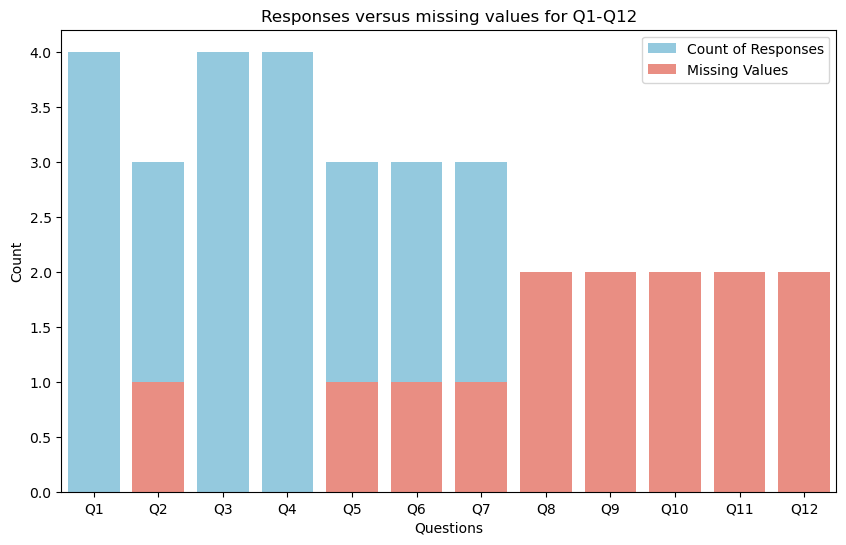

In [9]:
# Plot counts and missing values
plt.figure(figsize=(10, 6))
# Plotting the count of responses
sns.barplot(x=category_stats.columns, y=category_stats.loc['count'], color='skyblue', label='Count of Responses')
# Plotting the missing values
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='salmon', label='Missing Values')
# Adding titles and labels
plt.title('Responses versus missing values for Q1-Q12')
plt.xlabel('Questions')
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()

In [28]:
# Define a consistent color palette using the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=len(df.columns[3:].unique()))
# Create a mapping of each category to a color
unique_categories = df[df.columns[3:]].melt()['value'].dropna().unique()
color_map = {category: colorblind_palette[i] for i, category in enumerate(unique_categories)}
print(color_map)

def plot_questions(df_subset, title):
    plt.figure(figsize=(15, 8))
    max_count = df_subset.count().max() + 1  # Set max count for x-axis
    
    for i, col in enumerate(df_subset.columns, 1):
        ax = plt.subplot(3, 2, i)
        
        # Count occurrences of each response
        counts = df_subset[col].value_counts()
        
        # Create a bar plot using counts
        counts = counts.reindex(unique_categories, fill_value=0)  # Ensure all categories are represented
        counts.plot(kind='barh', ax=ax, color=[color_map[category] for category in counts.index])
        
        plt.title(f"Response Counts for {col}")
        plt.xlabel("Count")
        plt.ylabel("")
        
        # Set x-axis limits and format ticks
        ax.set_xlim(0, max_count)  # Set the same maximum x-axis limit for all plots
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure ticks are integers
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()


{'Åhlens': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Naturkompaniet': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Kappahl': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'XS Leker': (0.8352941176470589, 0.3686274509803922, 0.0), 'Stadium': (0.8, 0.47058823529411764, 0.7372549019607844), 'Cubus': (0.792156862745098, 0.5686274509803921, 0.3803921568627451)}


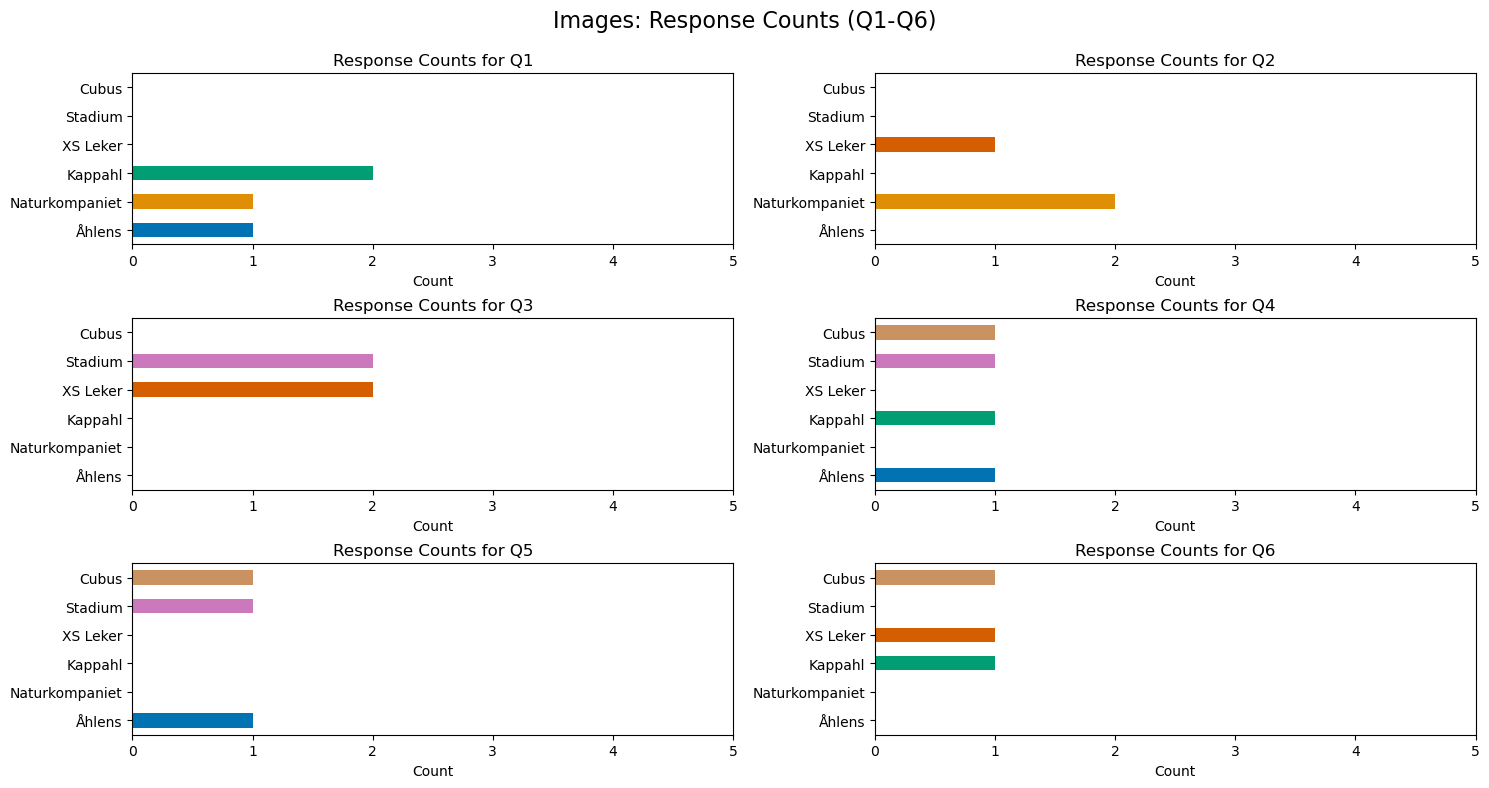

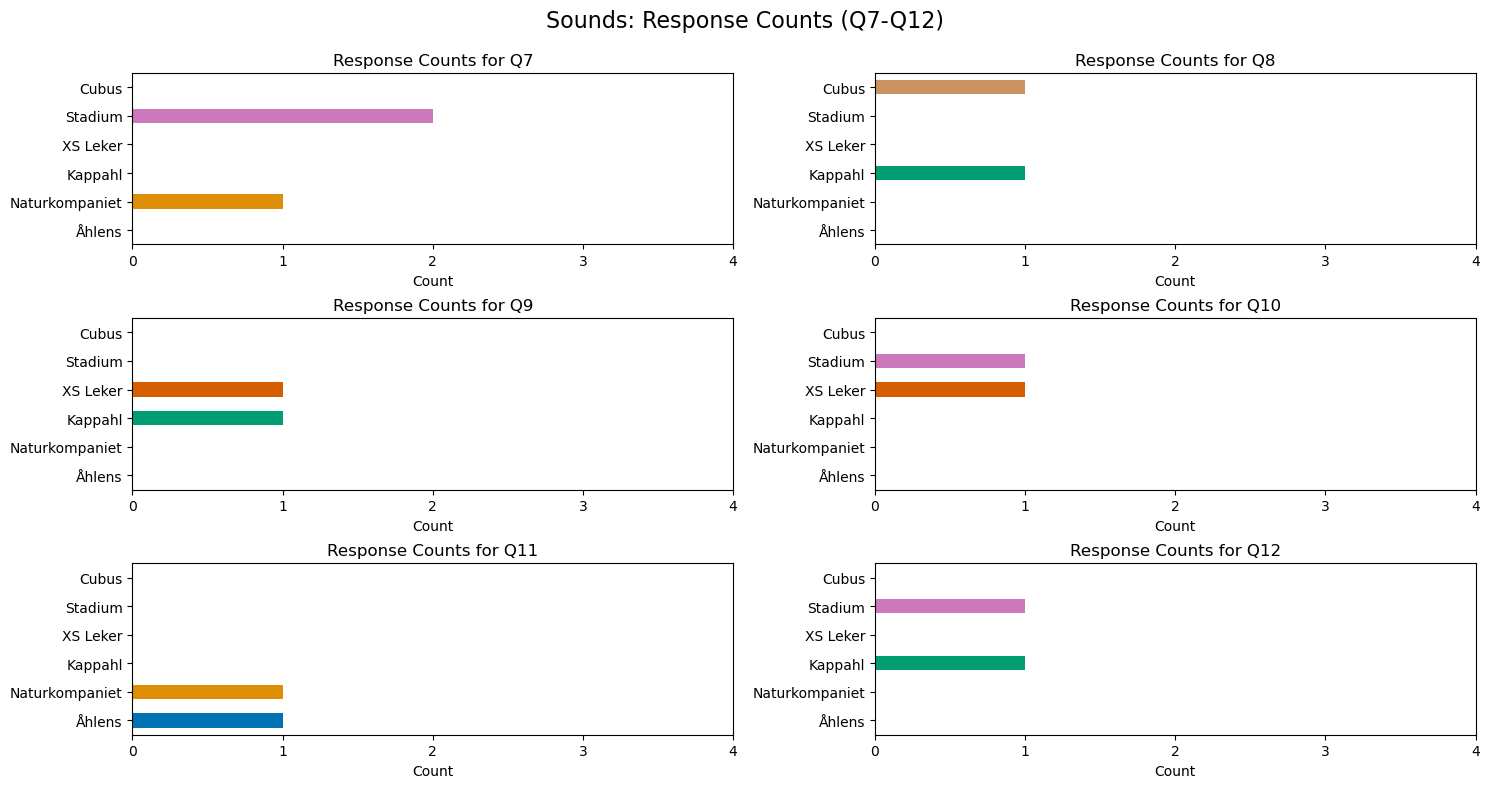

In [29]:
# Plot Q1-Q6
df_images = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
plot_questions(df_images, "Images: Response Counts (Q1-Q6)")

# Plot Q7-Q12
df_sounds = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']]
plot_questions(df_sounds, "Sounds: Response Counts (Q7-Q12)")

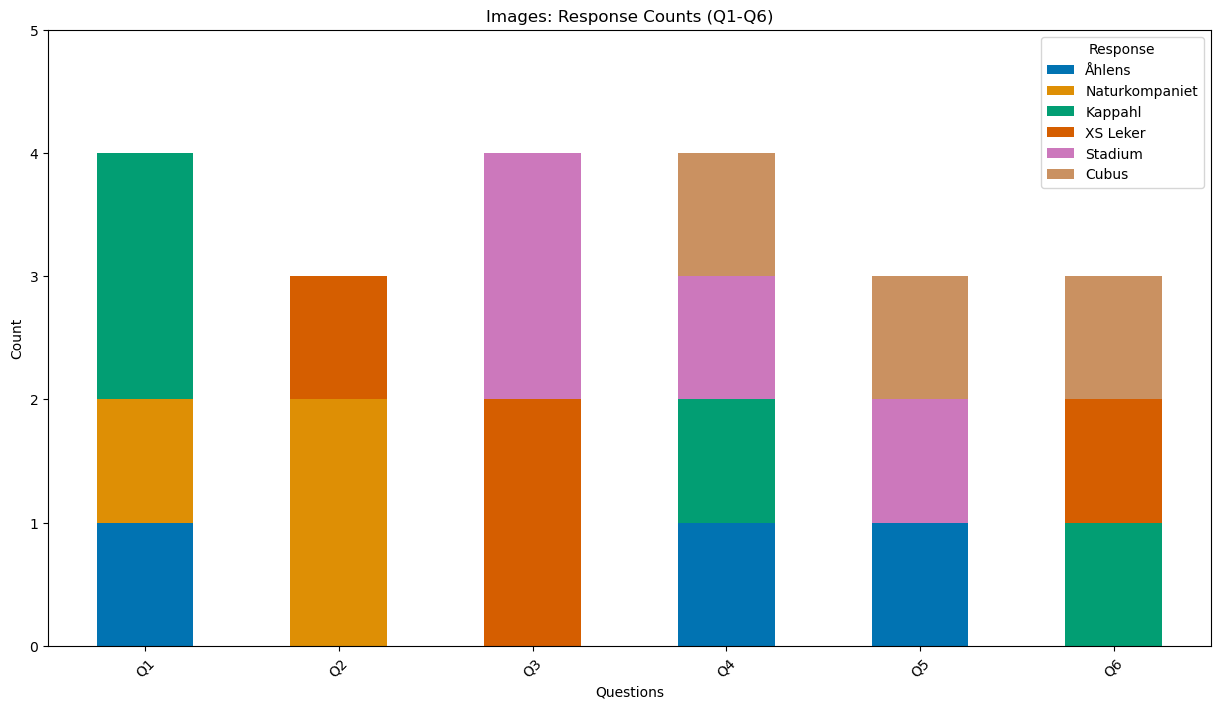

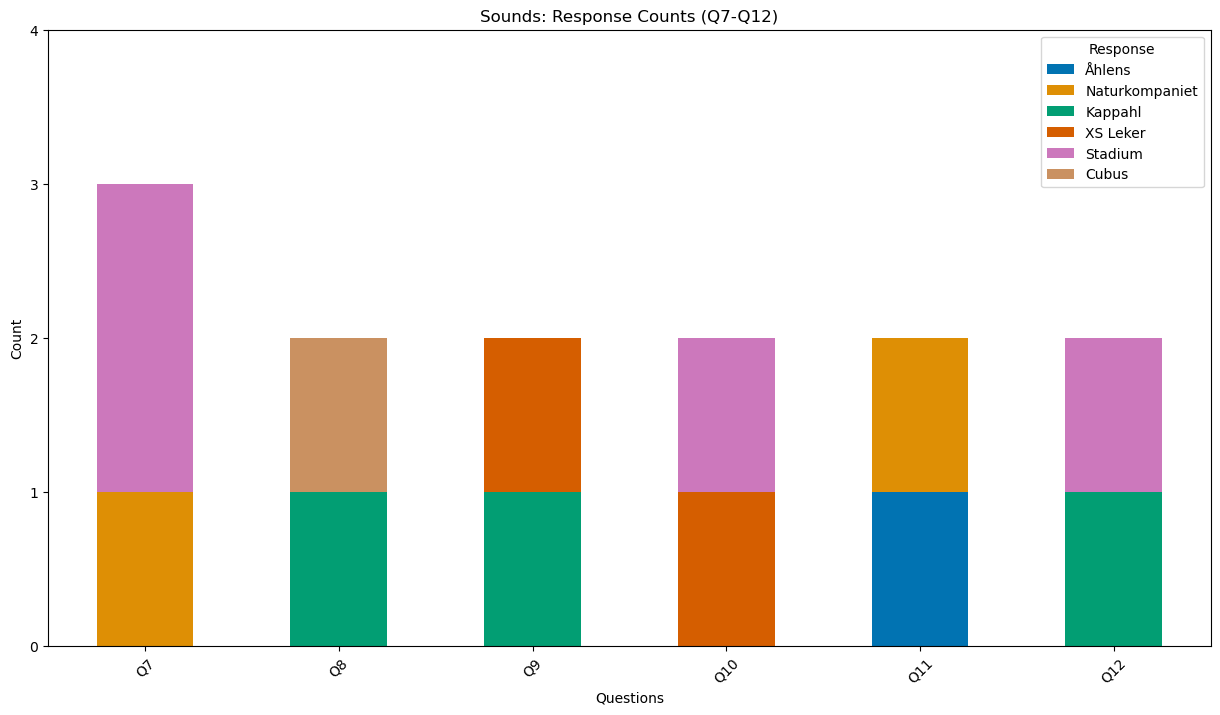

In [25]:
# Function to plot question responses as a stacked bar plot
def plot_stacked_bar(df_subset, title):
    # Count occurrences of each response per question
    response_counts = df_subset.apply(lambda x: x.value_counts()).fillna(0)
    
    # Plotting
    response_counts = response_counts.T  # Transpose for plotting
    response_counts = response_counts.reindex(columns=unique_categories, fill_value=0)  # Ensure all categories are represented
    
    response_counts.plot(kind='bar', stacked=True, figsize=(15, 8), color=color_map.values())
    plt.title(title)
    plt.xlabel("Questions")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.ylim(0, response_counts.sum(axis=1).max() + 1)  # Set y-axis limit
    # Ensure y-axis ticks are integers
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Only show integer ticks on y-axis
    plt.legend(title="Response", loc='upper right')
    plt.show()

# Plot Q1-Q6
df_images = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
plot_stacked_bar(df_images, "Images: Response Counts (Q1-Q6)")

# Plot Q7-Q12
df_sounds = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']]
plot_stacked_bar(df_sounds, "Sounds: Response Counts (Q7-Q12)")


## Calculate number of correct replies per question 

In [ ]:
df

## Correct answers 
Q1-Q6: Bilder 
1.Åhlens 
2.Stadium 
3.Kappahl
4.Cubus
5.Naturkompaniet
6.XS Leker 

Q7-Q12: Ljud
7. Stadium
8. XS
9. Kappahl 
10. Cubus 
11. Naturkompaniet 
12. Åhlens 

In [ ]:
# Define the correct answers
correct_answers = [
    'Åhlens', 'Stadium', 'Kappahl', 'Cubus', 'Naturkompaniet', 
    'XS Leker', 'Stadium', 'XS Leker', 'Kappahl', 'Cubus', 
    'Naturkompaniet', 'Åhlens'
]

# Create a copy of the DataFrame to hold correct/incorrect responses
df_correct = df.copy()
df_correct

In [ ]:
# Replace answers with 1 for correct and 0 for incorrect
for i in range(12):  # For Q1 to Q12
    df_correct[f'Q{i+1}'] = df_correct[f'Q{i+1}'].apply(lambda x: 1 if x == correct_answers[i] else 0)

print(df_correct)

In [ ]:
question_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']
question_df = df_correct[question_columns]
question_df

In [ ]:
# Calculate total correct answers per question
total_correct_per_question = question_df.sum(axis=0)
print("Correct answers per question", total_correct_per_question)

# Calculate total correct answers per participant
total_correct_per_participant = question_df.sum(axis=1)
print("Correct answers per participant", total_correct_per_participant)

# Calculate total correct for images versus sounds 
# Collapse correct for Q1-Q6
# Collapse correct for Q7-Q12

## For testing, generate random numbers if there are n participants 

In [ ]:
# Define columns and create an empty DataFrame
columns = ['A', 'B', 'C', 'D', 'E', 'F']  # Answers for each question
index = [f'Q{i+1}' for i in range(6)]  # Questions Q1 to Q6
df = pd.DataFrame(columns=columns, index=index)
#hf.input_data(index, columns)
df.loc['Q1'] = [0, 1, 1, 1, 0, 2]  # Replace with actual values for Q1 etc
df.loc['Q2'] = [1, 0, 1, 1, 0, 2]  
df.loc['Q3'] = [1, 0, 1, 1, 0, 2]  
df.loc['Q4'] = [0, 0, 2, 1, 0, 2]  
df.loc['Q5'] = [0, 0, 0, 3, 0, 2]  
df.loc['Q6'] = [0, 0, 5, 0, 0, 0]  

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Define the indices and columns
row_indices = [f'Q{i}' for i in range(1, 7)]
columns = ['A', 'B', 'C', 'D', 'E', 'F']

# Initialize an empty DataFrame
df = pd.DataFrame(index=row_indices, columns=columns)

# Fill the DataFrame with random integers such that the sum of each row equals 5
for row in row_indices:
    # Generate random integers that sum to n participants
    values = np.random.multinomial(participants, [1/6]*6)
    # Assign to the DataFrame
    df.loc[row] = values

In [ ]:
# Display the DataFrame that we are working with (inputted data or generated)
print(df)

## Plot number of correct replies for the image versus the sound category
- Make a combined plot that lists all 6 questions in one slide (one plot for image versus sound questions)
- Descriptive statistics
- Number of correct answers per question 
- Number of correct answers per category image versus sound 

## Select question row and plot results

In [ ]:
#Observed counts for each option A-F in question Q1
observed_counts = df.loc['Q6']
# Calculate the total number of responses
total_responses = sum(observed_counts)

In [ ]:
# Plot data 
# Convert the Series to a dictionary
data = observed_counts.to_dict()

# Plotting the data
plt.figure(figsize=(8, 6))
pd.Series(data).plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Response Counts for Each Category (A-F) for Q1')
plt.xticks(rotation=0)
# Set y-axis limit to the total number of replies
plt.ylim(0, total_responses)  # Set the y-axis limits
# Optionally, you can add a horizontal line at the total responses for clarity
plt.show()

## Chi-Square Goodness of Fit Test for separate questions
Tests whether the observed frequencies of a single categorical variable match expected frequencies under a specific hypothesis.

Hypothesis:
- Null Hypothesis (H₀): The observed distribution matches the expected distribution.
- Alternative Hypothesis (H₁): The observed distribution does not match the expected distribution.

The Chi-Square Goodness of Fit Test compares the observed distribution of responses to a uniform distribution, assuming that each answer choice (A-F) has an equal probability of being selected if participants are choosing randomly.

### Manual calculation

In [ ]:
# Calculate the expected counts assuming each option is equally likely
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Calculate the Chi-Square statistic by hand
chi_square_stat = sum(
    ((observed - expected) ** 2) / expected
    for observed, expected in zip(observed_counts, expected_counts)
)

# Print the calculated Chi-Square statistic
print("Chi-Square Statistic (calculated manually):", chi_square_stat)

# Degrees of freedom for this test
deg_freedom = len(observed_counts) - 1  # Here, df = 6 - 1 = 5

# To determine the significance level, we typically need a p-value.
# To fully implement this, we’d need to calculate or look up the critical value in a Chi-Square table.
# Example:
# For df=5 and significance level 0.05, the critical value is approximately 11.07
# So, we can interpret by comparing:

critical_value_95 = 11.07

# Calculate the p-value using the Chi-Square survival function
p_value = gammaincc(deg_freedom / 2, chi_square_stat / 2)
print("P-value: ", p_value)

#if chi_square_stat > critical_value_95:
if p_value < 0.05:
    print("The result is statistically significant at the 0.05 level.")
    print("The observed distribution of responses is significantly different from random guessing.")
else:
    print("The result is not statistically significant at the 0.05 level.")
    print("The observed distribution of responses is consistent with random guessing.")


### Using scipy.stats package

In [ ]:
# Calculate the total number of responses for Q1
total_responses = sum(observed_counts)

# Expected counts assuming equal probability for each option (random guessing)
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Perform the Chi-Square Goodness of Fit test
chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

# Output the results
print("Total number of responses:", total_responses)
print("Chi-Square Statistic:", chi2_stat) # How much the observed counts differ from the expected counts. Higher values indicate larger deviations.
print("p-value:", p_value) # A low p-valu, it suggests that the distribution of responses in Q1 is not likely to be due to random guessing, and some options may be selected more often than expected by chance.

# Interpretation of results
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. This is less than the significance level of 0.05.")
    print("We reject the null hypothesis, suggesting that the observed distribution of responses for question Q1")
    print("is significantly different from what would be expected by random guessing. Some answer options may be chosen more often.")
else:
    print(f"The p-value is {p_value:.4f}. This is greater than the significance level of 0.05.")
    print("We do not reject the null hypothesis, indicating that the observed distribution of responses for question Q1")
    print("is not significantly different from random guessing. The responses appear consistent with chance.")

## Crochan Q test for omnibus testing

In [ ]:
# Specify correct answers for each question
correct_answers = {
    'Q1': 'A',
    'Q2': 'C',
    'Q3': 'D',
    'Q4': 'F',
    'Q5': 'A',
    'Q6': 'B'
}

## Generate sample data to test 

In [ ]:
# Each row is a participant, each column is their answer to that question
participant_responses = pd.DataFrame({
    'Q1': ['B', 'A', 'C', 'F', 'D'],  # what each participant answered for Q1
    'Q2': ['C', 'C', 'B', 'A', 'F'],  # ... Q2 and so on 
    'Q3': ['D', 'D', 'D', 'C', 'A'],  
    'Q4': ['F', 'F', 'F', 'D', 'B'],  
    'Q5': ['A', 'C', 'D', 'A', 'E'],  
    'Q6': ['B', 'B', 'C', 'B', 'D']   
})

participant_responses

In [ ]:
def convert_to_binary(responses, correct_answers):
    """
    Convert participant responses to binary format (1 for correct, 0 for incorrect)
    
    Parameters:
    responses (pd.DataFrame): DataFrame where each row is a participant and each column is their answer
    correct_answers (dict): Dictionary mapping question number to correct answer
    
    Returns:
    pd.DataFrame: Binary DataFrame where 1 indicates correct answer, 0 indicates incorrect
    """
    binary_df = pd.DataFrame(index=responses.index, columns=responses.columns)
    
    for question in responses.columns:
        binary_df[question] = (responses[question] == correct_answers[question]).astype(int)
    
    return binary_df

binary_responses = convert_to_binary(participant_responses, correct_answers)
print(binary_responses)
print(correct_answers)

In [ ]:
# Print original responses and binary format
print("Original participant responses:")
print(participant_responses)
print("\nBinary format (1 = correct, 0 = incorrect):")
print(binary_responses)

# Let's also see how each participant did overall
print("\nTotal correct answers per participant:")
print(binary_responses.sum(axis=1))

# And how many got each question right
print("\nNumber of correct answers per question:")
print(binary_responses.sum(axis=0))

print("\nSuccess rate for each question:")
print(binary_responses.mean() * 100)  # Percentage correct for each question

In [ ]:
# Test whether the questions have significantly different levels of difficulty.  
# Compare how the same participants performed across all questions.

In [ ]:
binary_responses

In [ ]:
# Transpose the DataFrame to get the required input format
data_for_cochrans_q = binary_responses.T.values  # Transpose to get questions as rows
print(data_for_cochrans_q)

# Calculate Crochan's Q
results = cochrans_q(data_for_cochrans_q)

# Access the Q statistic and p-value
q_statistic = results.statistic
p_value = results.pvalue

print(f"Cochran's Q Statistic: {q_statistic}")
print(f"P-value: {p_value}")

In [ ]:
# Interpretation 

# Interpretation based on Cochran's Q and p-value
if p_value < 0.05:
    print("The p-value is less than 0.05, indicating significant differences among the questions.")
    if q_statistic > 0:
        print(f"Cochran's Q Statistic: {q_statistic} suggests that there is variability in responses.")
        print("At least one question differs significantly from the others in the proportion of correct answers.")
else:
    print("The p-value is greater than or equal to 0.05, indicating no significant differences among the questions.")
    print(f"Cochran's Q Statistic: {q_statistic} indicates that the responses are relatively uniform across questions.")

## Continue with McNemar pairwise tests
Makes sense if we count the total number of correct versus incorrect answers per question. Suppose it needs data on individual level though.

In [ ]:
"""
Conclusion: 
Use Crochan Q test. McNemar test for post hoc tests. Please note that although the data is coded as right or wrong, the ratio is not 50%. Correct option is only 1/6. 

If you want to directly test whether the observed proportion of correct answers differs from random guessing across all questions, you might also consider a binomial test or chi-square goodness-of-fit test for each question individually. This would check whether the proportion of correct answers per question differs significantly from 16.67%, which represents random guessing. 

In short, the 1:5 ratio of correct to incorrect options doesn’t impact the binary setup of Cochran’s Q test but does affect the baseline expectation for correct answers if guessing is assumed. You can use Cochran’s Q to explore consistency across questions, and if needed, conduct additional analyses to examine how actual correctness rates align with guessing probability.
"""

Antalet rätt 
Presentation 
